In [12]:
!pip install jupyter notebook
!pip install tensorflow==2.11.1 tensorflow-io==0.31.0 matplotlib

You should consider upgrading via the 'c:\users\dakota\desktop\personal projects\coding\python\stage_zero\kick classifier\ac-venv\scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization

#Finds available GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [263]:
#load waveform as an array
def SampleToTensor(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [264]:
#These store the directories for the positive and negative data for training the model
POS = os.path.join('data', 'kick-samples')
NEG = os.path.join('data', 'non-kick-samples')

In [13]:
#These are creating the TensorFlow datasets from the .wav files stored in the directories
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

NameError: name 'POS' is not defined

In [14]:
#This is mixing up the positive and negative datasets into one dataset called "data".
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

NameError: name 'pos' is not defined

In [267]:
# Initialize an empty list to store lengths of audio files
lengths = []

# Loop over each file in the 'kick-samples' directory
for file in os.listdir(os.path.join('data', 'kick-samples')):

    # Convert each audio file to a tensor waveform using the SampleToTensor function
    tensor_wave = SampleToTensor(os.path.join('data', 'kick-samples', file))

    # Append the length of the tensor (i.e., the length of the audio file) to the 'lengths' list
    lengths.append(len(tensor_wave))

# At the end, 'lengths' list contains the lengths of all audio files in the 'kick-samples' directory

In [268]:
#to visualize the mean
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=52486>

In [269]:
#to visualize the min
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=15360>

In [270]:
#to visualize the max
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=64000>

In [271]:
"""
    This function takes a file path and a label as input. It reads the audio file at the given path and converts it into a waveform.
    The waveform is then truncated or zero-padded to a fixed length of 48000. 
    A Short-Time Fourier Transform (STFT) is applied to the waveform to convert it into a spectrogram.
    The absolute values of the spectrogram are taken to ensure it is real-valued, and an extra dimension is added to the spectrogram tensor for compatibility with Conv2D layers.
    The function returns the processed spectrogram and the original label.
"""

def SampleSpectrogram(file_path, label):
    wav = SampleToTensor(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    # Ensure the padding is added at the end of the tensor
    wav = tf.concat([wav, zero_padding],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [272]:
#grabs a random dataset to test a spectrogram on
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

#runs the sample through the SampleSpectrogram function
spectrogram, label = SampleSpectrogram(filepath, label)

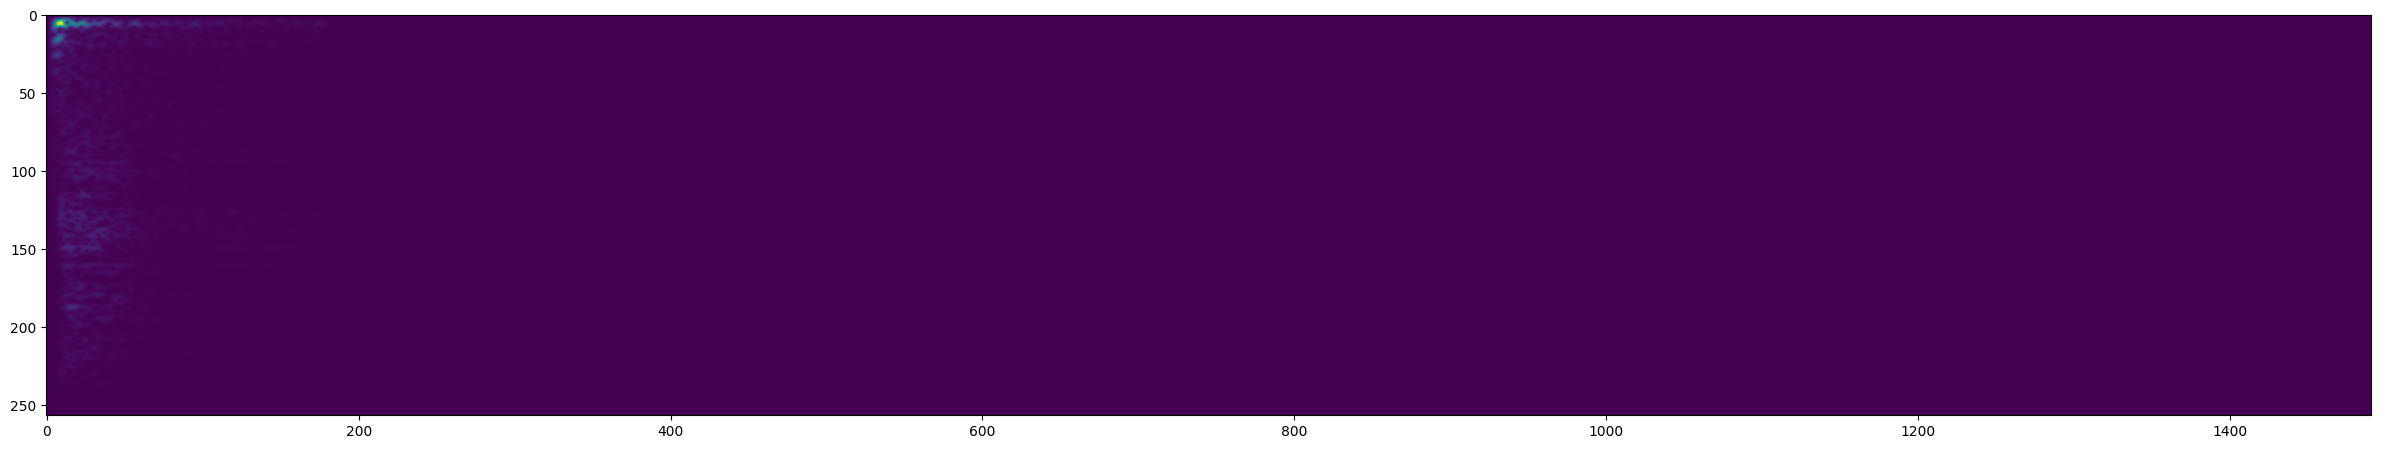

In [274]:
#visualizes the spectrogram
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [275]:
#tensorflow data pipeline
#
# The 'map' function applies the 'SampleSpectrogram' function to each element in the 'data' dataset.
data = data.map(lambda x, y: SampleSpectrogram(x, y))

# The 'cache' function stores the dataset in memory for faster access during training.
data = data.cache()

# The 'shuffle' function randomly shuffles the elements of the dataset to ensure that the model does not learn any inherent order in the data.
data = data.shuffle(buffer_size=1000)

# The 'batch' function groups the dataset into batches of 16 for efficient training.
data = data.batch(16)

# The 'prefetch' function preloads the next 8 batches while the current batch is being processed to optimize training speed.
data = data.prefetch(8)

In [276]:
len(data)

47

In [277]:
#split into training and testing partitions based on 70%-30% division
num_samples = tf.data.experimental.cardinality(data).numpy()
num_train_samples = int(0.7 * num_samples)
num_test_samples = num_samples - num_train_samples

train = data.take(num_train_samples)
test = data.skip(num_train_samples).take(num_test_samples)

In [278]:
len(test)

15

In [279]:
# Calculate the total number of test samples in the training dataset and print the result
num_test_samples = tf.data.experimental.cardinality(train).numpy()
print(f"Number of test samples: {num_test_samples}")

Number of test samples: 32


In [281]:
"""
    This function takes a file path and a label as input. It reads the audio file at the given path and converts it into a waveform.
    The waveform is then truncated or zero-padded to a fixed length of 14974. 
    A Short-Time Fourier Transform (STFT) is applied to the waveform to convert it into a spectrogram.
    The absolute values of the spectrogram are taken to ensure it is real-valued, and an extra dimension is added to the spectrogram tensor for compatibility with Conv2D layers.
    The function returns the processed spectrogram and the original label.
"""

def SampleSpectrogram(file_path, label):
    file_path = tf.py_function(func=lambda x: x.numpy().decode('utf-8'), inp=[file_path], Tout=tf.string)
    wav = SampleToTensor(file_path)
    wav_shape = tf.shape(wav)[0]
    zero_padding = tf.zeros([14974] - wav_shape, dtype=tf.float32)
    # Ensure the padding is added at the end of the tensor
    wav = tf.concat([wav, zero_padding],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label


In [283]:
#sequential model - V1 Model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [6]:
#sequential model - V2 Model
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(BatchNormalization())
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [7]:
#defines the compiler for the neural network
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [8]:
#shows summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 batch_normalization (BatchN  (None, 1489, 255, 8)     32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 batch_normalization_1 (Batc  (None, 1487, 253, 8)     32        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 64)                1

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('path_to_my_model.h5')  

In [286]:
#for training the model... epochs the number of training iterations
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
32/32 [==============================] - 4744s 149s/step - loss: 0.8514 - recall_5: 0.9161 - precision_5: 0.8973 - val_loss: 0.2092 - val_recall_5: 0.9839 - val_precision_5: 0.9839
Epoch 2/4
 9/32 [=======>......................] - ETA: 52:16 - loss: 0.1576 - recall_5: 0.9750 - precision_5: 1.0000

In [ ]:
# Save the model
model.save('edm_kick_v2.h5')

In [ ]:
#prints the training history keys
print(hist.history.keys())

NameError: name 'hist' is not defined

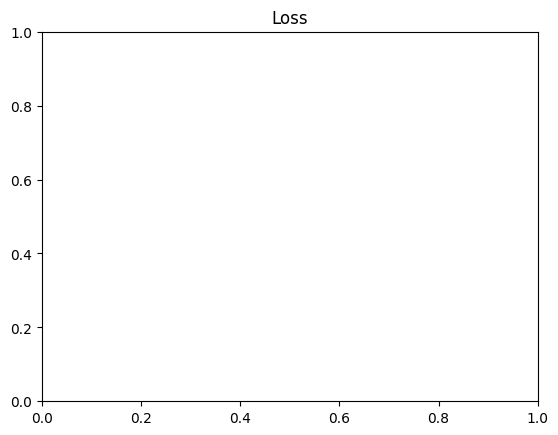

In [3]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision_4'], 'r')
plt.plot(hist.history['val_precision_4'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall_4'], 'r')
plt.plot(hist.history['val_recall_4'], 'b')
plt.show()

In [15]:
# hist.history returns a dictionary storing the training loss values and metrics values at each epoch. 
# If validation is performed, it also includes validation loss values and validation metrics values.
hist.history

NameError: name 'hist' is not defined

In [ ]:
#grabs one test sample to test against the trained neural network
X_test, y_test = test.as_numpy_iterator().next()


In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
#defines var for song path
song = os.path.join('data', 'full-song', 'song.mp3')

In [ ]:
#converts song to tensor
wav = load_mp3_16k_mono(song)

In [ ]:
#converts song to slices... same size as the training data... len(audio_slices) gives the total number of clips
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
# This line of code retrieves the next item from the audio_slices iterator.
# 'samples' will contain the audio data for the next slice, and 'index' will contain the corresponding index of that slice.
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
#converts song to spectrogram
def preprocess_song(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
#Converts longer clips into windows and makes predictions
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_song)
audio_slices = audio_slices.batch(64) #og was 64 here

In [ ]:
# The first line uses the trained model to make predictions on the audio slices. 
# The model returns a probability for each slice, indicating how likely it thinks that slice contains a kick drum sound.
# The second line then converts these probabilities into binary predictions.
# If the model's probability is greater than 0.5 (indicating it's more likely than not that the slice contains a kick drum), 
# the prediction is converted to 1 (representing a positive prediction). 
# Otherwise, the prediction is converted to 0 (representing a negative prediction).
yhat = model.predict(audio_slices)
#change the 0.X number to increase the level of confidence to log a prediction
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
# Initialize an empty list to store frame numbers
frame_numbers = []

# Enumerate over the audio_slices. 'i' is the index and 'batch' is the current batch of audio slices.
for i, batch in enumerate(audio_slices):
    # Use the trained model to make predictions on the current batch of audio slices
    predictions = model.predict(batch)
    
    # Enumerate over the predictions. 'j' is the index and 'prediction' is the current prediction.
    for j, prediction in enumerate(predictions):
        # If the prediction is greater than 0.5 (indicating the model thinks the slice likely contains a kick drum)
        if prediction > 0.5:
            # Calculate the frame number corresponding to the current slice
            # This is done by multiplying the batch index by the number of predictions per batch and adding the index of the current prediction
            # The result is then multiplied by 48000 to convert from slice index to frame number
            frame_number = (i * len(predictions) + j) * 48000
            
            # Append the frame number to the list of frame numbers
            frame_numbers.append(frame_number)

# Print the list of frame numbers
print(frame_numbers)

In [ ]:
#prints number of occurences
tf.math.reduce_sum(yhat)

In [ ]:
#loop over songs in file path and make predictions... not fully implemented yet.
results = {}
for file in os.listdir(os.path.join('data', 'full-song')):
    FILEPATH = os.path.join('data','full-song', file)
    
    wav = SampleToTensor(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_song)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results